In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/phasmote/final_data.csv
/kaggle/input/phasmote/pha_map.csv


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
df = pd.read_csv("/kaggle/input/phasmote/final_data.csv")

In [6]:
y = pd.read_csv("/kaggle/input/phasmote/pha_map.csv")

In [7]:
X = df.drop(columns=['albedo', 'rot_per', 'e', 'a', 'q', 'om', 'w', 'ma', 'ad'])

In [8]:
X.isnull().sum()

H           0
diameter    0
i           0
n           0
per         0
moid_ld     0
dtype: int64

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, f1_score, roc_curve, ConfusionMatrixDisplay, RocCurveDisplay
from imblearn.metrics import sensitivity_specificity_support, classification_report_imbalanced
from imblearn.over_sampling import SMOTE

# Resampling

In [10]:
st = SMOTE(random_state=42)
X_resampled, y_resampled = st.fit_resample(X, y)

In [11]:
X_resampled.shape

(2619186, 6)

In [12]:
y_resampled.value_counts()

pha
0      1309593
1      1309593
Name: count, dtype: int64

In [13]:
X_train,X_test,y_train,y_test = train_test_split(X_resampled,y_resampled, test_size=0.2, random_state=43)

In [14]:
y_train.value_counts()

pha
1      1048325
0      1047023
Name: count, dtype: int64

In [15]:
y_test.value_counts()

pha
0      262570
1      261268
Name: count, dtype: int64

In [16]:
!pip install dask

In [17]:
!python -m pip install dask distributed --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 24.6 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 2.3 MB/s eta 0:00:00
  Attempting uninstall: dask
    Found existing installation: dask 2024.5.2
    Uninstalling dask-2024.5.2:
      Successfully uninstalled dask-2024.5.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask-expr 1.1.2 requires dask==2024.5.2, but you have dask 2024.6.2 which is incompatible.


In [ ]:
import os
os.cpu_count()

In [18]:
from dask.distributed import Client
client = Client(n_workers=16)
client

/opt/conda/lib/python3.10/site-packages/distributed/client.py:1394: VersionMismatchWarning: Mismatched versions found

+---------+----------+-----------+----------+
| Package | Client   | Scheduler | Workers  |
+---------+----------+-----------+----------+
| dask    | 2024.5.2 | 2024.5.2  | 2024.6.2 |
+---------+----------+-----------+----------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 16
Total threads: 16,Total memory: 30.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37865,Workers: 16
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 30.00 GiB
Comm: tcp://127.0.0.1:37543,Total threads: 1
Dashboard: http://127.0.0.1:41649/status,Memory: 1.88 GiB
Nanny: tcp://127.0.0.1:46477,


In [19]:
import joblib

# Training with Random forest

In [20]:
y_train = y_train.squeeze()
y_train

1205167    0
575514     0
1212305    0
1847891    1
1411332    1
          ..
1106227    0
1525776    1
1439802    1
2484501    1
1613617    1
Name: pha, Length: 2095348, dtype: int64

In [19]:
rf = RandomForestClassifier()
with joblib.parallel_backend("dask", scatter=[X_train,y_train]):
    rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)

/opt/conda/lib/python3.10/site-packages/distributed/client.py:1394: VersionMismatchWarning: Mismatched versions found

+---------+----------+-----------+----------+
| Package | Client   | Scheduler | Workers  |
+---------+----------+-----------+----------+
| dask    | 2024.6.2 | 2024.5.2  | 2024.6.2 |
+---------+----------+-----------+----------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))
/opt/conda/lib/python3.10/site-packages/distributed/client.py:1394: VersionMismatchWarning: Mismatched versions found

+---------+----------+-----------+----------+
| Package | Client   | Scheduler | Workers  |
+---------+----------+-----------+----------+
| dask    | 2024.6.2 | 2024.5.2  | 2024.6.2 |
+---------+----------+-----------+----------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))
Exception ignored in: <bound method GCDiagnosis._gc_callback of <distributed.utils_perf.GCDiagnosis object at 0x7c05546c99c0>>
Traceback (most recent call

In [18]:
accuracy_score(y_test,y_pred)

0.9999790011415743

In [19]:
confusion_matrix(y_test,y_pred)

array([[262559,     11],
       [     0, 261268]])

In [20]:
print(classification_report_imbalanced(y_test,y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      1.00      1.00      1.00      1.00      1.00    262570
          1       1.00      1.00      1.00      1.00      1.00      1.00    261268

avg / total       1.00      1.00      1.00      1.00      1.00      1.00    523838



In [21]:
print(sensitivity_specificity_support(y_test, y_pred))

(array([0.99995811, 1.        ]), array([1.        , 0.99995811]), array([262570, 261268]))


In [22]:
from sklearn.model_selection import RandomizedSearchCV

model = RandomForestClassifier()

param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 20, 30, 50]
}

rand = RandomizedSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

In [ ]:
with joblib.parallel_backend("dask", scatter=[X_train,y_train]):
    rand.fit(X_train,y_train)

/opt/conda/lib/python3.10/site-packages/distributed/client.py:1394: VersionMismatchWarning: Mismatched versions found

+---------+----------+-----------+----------+
| Package | Client   | Scheduler | Workers  |
+---------+----------+-----------+----------+
| dask    | 2024.6.2 | 2024.5.2  | 2024.6.2 |
+---------+----------+-----------+----------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))
/opt/conda/lib/python3.10/site-packages/distributed/client.py:1394: VersionMismatchWarning: Mismatched versions found

+---------+----------+-----------+----------+
| Package | Client   | Scheduler | Workers  |
+---------+----------+-----------+----------+
| dask    | 2024.6.2 | 2024.5.2  | 2024.6.2 |
+---------+----------+-----------+----------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))
/opt/conda/lib/python3.10/site-packages/distributed/client.py:1394: VersionMismatchWarning: Mismatched versions found

+---------+----------+-----------+-

In [29]:
rand.best_params_

Process Dask Worker process (from Nanny):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.10/site-packages/distributed/process.py", line 202, in _run
    target(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/distributed/nanny.py", line 1019, in _run
    asyncio_run(run(), loop_factory=get_loop_factory())
  File "/opt/conda/lib/python3.10/site-packages/distributed/compatibility.py", line 236, in asyncio_run
    return loop.run_until_complete(main)
  File "/opt/conda/lib/python3.10/asyncio/base_events.py", line 636, in run_until_complete
    self.run_forever()
  File "/opt/conda/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
    self._run_once()
  File "/opt/conda/lib/python3.10/asyncio/base_events.py", line 18

AttributeError: 'RandomizedSearchCV' object has no attribute 'best_params_'

Process Dask Worker process (from Nanny):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.10/site-packages/distributed/process.py", line 202, in _run
    target(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/distributed/nanny.py", line 1019, in _run
    asyncio_run(run(), loop_factory=get_loop_factory())
  File "/opt/conda/lib/python3.10/site-packages/distributed/compatibility.py", line 236, in asyncio_run
    return loop.run_until_complete(main)
  File "/opt/conda/lib/python3.10/asyncio/base_events.py", line 636, in run_until_complete
    self.run_forever()
  File "/opt/conda/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
    self._run_once()
  File "/opt/conda/lib/python3.10/asyncio/base_events.py", line 18

In [ ]:
rand.best_score_

In [ ]:
##Training with best parameters
rfbest = RandomForestClassifier(n_estimators= 300, max_depth= 30)
with joblib.parallel_backend("dask", scatter=[X_train,y_train]):
    rfbest.fit(X_train,y_train)

In [ ]:
y_pred = rfbest.predict(X_test)

In [31]:
from imblearn.metrics import classification_report_imbalanced

In [ ]:
print(classification_report_imbalanced(y_test,y_pred))

In [ ]:
##Plotting Confusion matrix

cm = confusion_matrix(y_test, y_pred, labels=rfbest.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=rfbest.classes_)
disp.plot()
plt.show()

In [ ]:
##Plotting ROC Curve

ax = plt.gca()
roc_display = RocCurveDisplay.from_estimator(rfbest, X_test, y_test, ax=ax, alpha=0.8)
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()

In [ ]:
print(sensitivity_specificity_support(y_true, y_pred, average='macro'))

In [ ]:
print(sensitivity_specificity_support(y_true, y_pred, average='micro'))

In [ ]:
print(sensitivity_specificity_support(y_true, y_pred, average='weighted'))

# Training with XGBoost

In [30]:
xgb = XGBClassifier()
with joblib.parallel_backend("dask", scatter=[X_train,y_train]):
    xgb.fit(X_train,y_train)

In [31]:
y_pred = xgb.predict(X_test)

In [32]:
accuracy_score(y_test,y_pred)

0.9999007326692604

In [33]:
confusion_matrix(y_test,y_pred)

array([[262520,     50],
       [     2, 261266]])

In [34]:
roc_auc_score(y_test,y_pred)

0.9999009598073326

In [39]:
from sklearn.model_selection import RandomizedSearchCV
xgb = XGBClassifier()
param_grid = {
    'objective' : [None, 'binary:logistic', 'binary:hinge'],
    'max_depth': [None, 20, 30, 50],
    'eta' : [0.0001, 0.001, 0.01, 0.1, 1],
    'tree_method' : ['auto', 'exact']
}

rand2 = RandomizedSearchCV(xgb, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

In [40]:
with joblib.parallel_backend("dask", scatter=[X_train,y_train]):
    rand2.fit(X_train,y_train)

In [41]:
rand2.best_params_

{'tree_method': 'exact',
 'objective': 'binary:hinge',
 'max_depth': 20,
 'eta': 0.01}

In [42]:
rand2.best_score_

0.9999508434912177

In [43]:
##Training with best parameters
xgbest = XGBClassifier(tree_method='exact',
 objective= 'binary:hinge',
 max_depth=20,
 eta=0.01)
xgbest.fit(X_train,y_train)
y_pred = xgbest.predict(X_test)

In [44]:
print(classification_report_imbalanced(y_test,y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      1.00      1.00      1.00      1.00      1.00    262570
          1       1.00      1.00      1.00      1.00      1.00      1.00    261268

avg / total       1.00      1.00      1.00      1.00      1.00      1.00    523838



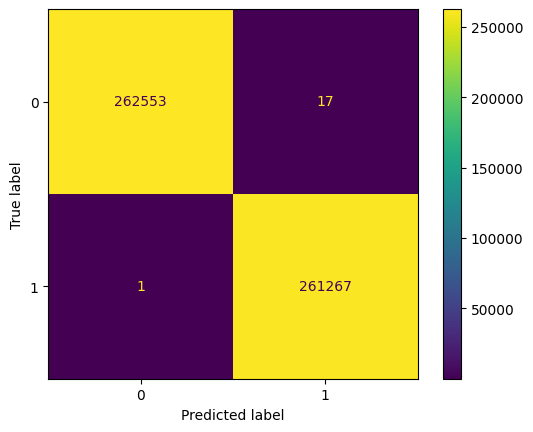

In [45]:
##Plotting Confusion matrix

cm = confusion_matrix(y_test, y_pred, labels=xgbest.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=xgbest.classes_)
disp.plot()
plt.show()

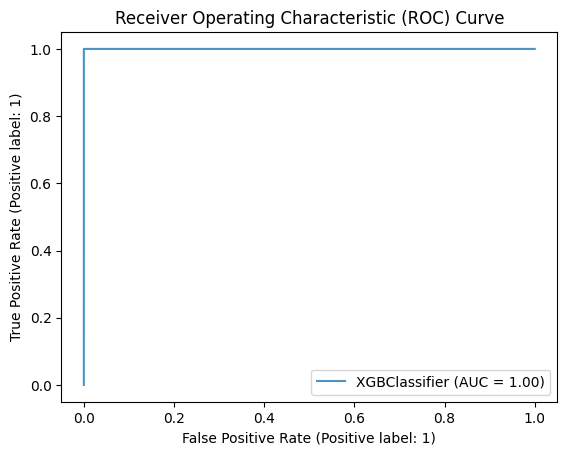

In [46]:
##Plotting ROC Curve

ax = plt.gca()
roc_display = RocCurveDisplay.from_estimator(xgbest, X_test, y_test, ax=ax, alpha=0.8)
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()

In [47]:
print(sensitivity_specificity_support(y_test, y_pred))

(array([0.99993526, 0.99999617]), array([0.99999617, 0.99993526]), array([262570, 261268]))


In [48]:
print(sensitivity_specificity_support(y_test, y_pred, average='macro'))

(0.9999657139364957, 0.9999657139364957, None)


In [49]:
print(sensitivity_specificity_support(y_test, y_pred, average='micro'))

(0.9999656382316671, 0.9999656382316671, None)


In [50]:
print(sensitivity_specificity_support(y_test, y_pred, average='weighted'))

(0.9999656382316671, 0.9999657896413242, None)


# Training with LightGBM

In [32]:
lgb = LGBMClassifier()
lgb.fit(X_train,y_train)

[LightGBM] [Info] Number of positive: 1048325, number of negative: 1047023
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.161982 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 2095348, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001243
[LightGBM] [Info] Start training from score 0.001243


LGBMClassifier()

In [33]:
y_pred = lgb.predict(X_test)

In [34]:
accuracy_score(y_test,y_pred)

0.9998854607722235

In [35]:
confusion_matrix(y_test,y_pred)

array([[262512,     58],
       [     2, 261266]])

In [36]:
roc_auc_score(y_test,y_pred)

0.9998857257745033

In [37]:
param_grid = {
    'num_leaves': [30, 50, 70],
    'num_iterations': [100, 200, 300, 500],
    'max_depth': [None, 20, 30, 50],
    'learning_rate' : [0.0001, 0.001, 0.01, 0.1, 1],
}

rand3 = RandomizedSearchCV(lgb, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

In [38]:
with joblib.parallel_backend("dask", scatter=[X_train,y_train]):
    rand3.fit(X_train,y_train)

/opt/conda/lib/python3.10/site-packages/distributed/client.py:1394: VersionMismatchWarning: Mismatched versions found

+---------+----------+-----------+----------+
| Package | Client   | Scheduler | Workers  |
+---------+----------+-----------+----------+
| dask    | 2024.6.2 | 2024.5.2  | 2024.6.2 |
+---------+----------+-----------+----------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))
/opt/conda/lib/python3.10/site-packages/distributed/client.py:1394: VersionMismatchWarning: Mismatched versions found

+---------+----------+-----------+----------+
| Package | Client   | Scheduler | Workers  |
+---------+----------+-----------+----------+
| dask    | 2024.6.2 | 2024.5.2  | 2024.6.2 |
+---------+----------+-----------+----------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))
/opt/conda/lib/python3.10/site-packages/distributed/client.py:1394: VersionMismatchWarning: Mismatched versions found

+---------+----------+-----------+-

[LightGBM] [Info] Number of positive: 838660, number of negative: 837618


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838660, number of negative: 837618
[LightGBM] [Info] Number of positive: 838660, number of negative: 837618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.173955 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676278, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001243
[LightGBM] [Info] Start training from score 0.001243
[LightGBM] [Info] Number of positive: 838660, number of negative: 837618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.124305 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.128328 seconds.
You can set `force_col_wise=true` to remove the overhead.
[

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838660, number of negative: 837618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 3.814897 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676278, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001243
[LightGBM] [Info] Start training from score 0.001243
[LightGBM] [Info] Number of positive: 838660, number of negative: 837619
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 3.832128 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676279, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initsco

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 3.691070 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676279, number of used features: 6
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001242
[LightGBM] [Info] Start training from score 0.001242
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits wi

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No furthe

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Info] Number of positive: 838660, number of negative: 837618
[LightGBM] [Info] Number of posi

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001243
[LightGBM] [Info] Start training from score 0.001243
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Info] Number of positive: 838660, number of negative: 837618
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Info] Number of positive: 838660, number of negative: 837618
[Light

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Info] Number of positive: 838660, number of negative: 837618
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Info] Auto-choosing 

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 3.776916 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676279, number of used features: 6
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001242
[LightGBM] [Info] Start training from score 0.001242
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits wi

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1048325, number of negative: 1047023
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.286637 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 2095348, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001243
[LightGBM] [Info] Start training from score 0.001243


In [39]:
rand3.best_params_

{'num_leaves': 70,
 'num_iterations': 500,
 'max_depth': 20,
 'learning_rate': 0.01}

In [40]:
rand3.best_score_

0.9999117091641823

In [41]:
##Training with best parameters
lgbest = LGBMClassifier(num_leaves= 70,
 num_iterations= 500,
 max_depth= 20,
 learning_rate= 0.01)
with joblib.parallel_backend("dask", scatter=[X_train,y_train]):
    lgbest.fit(X_train,y_train)

y_pred = lgbest.predict(X_test)

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1048325, number of negative: 1047023
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.364685 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 2095348, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001243
[LightGBM] [Info] Start training from score 0.001243


In [42]:
print(classification_report_imbalanced(y_test,y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      1.00      1.00      1.00      1.00      1.00    262570
          1       1.00      1.00      1.00      1.00      1.00      1.00    261268

avg / total       1.00      1.00      1.00      1.00      1.00      1.00    523838



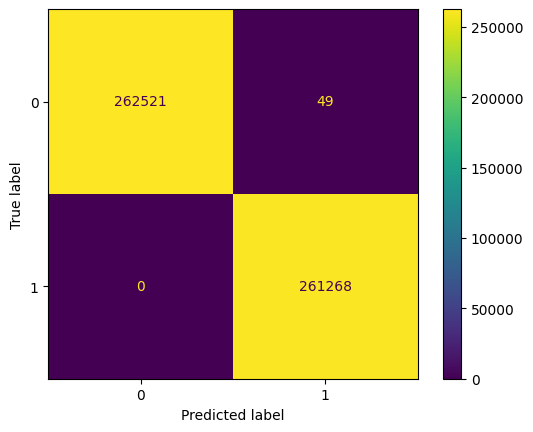

In [43]:
##Plotting Confusion matrix

cm = confusion_matrix(y_test, y_pred, labels=lgbest.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=lgbest.classes_)
disp.plot()
plt.show()

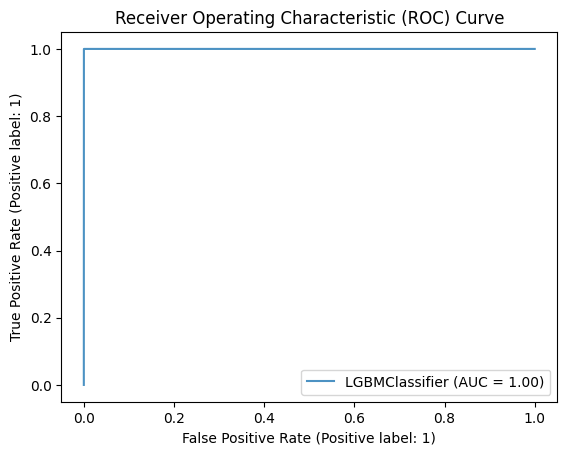

In [44]:
##Plotting ROC Curve

ax = plt.gca()
roc_display = RocCurveDisplay.from_estimator(lgbest, X_test, y_test, ax=ax, alpha=0.8)
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()

In [45]:
print(sensitivity_specificity_support(y_test, y_pred))

(array([0.99981338, 1.        ]), array([1.        , 0.99981338]), array([262570, 261268]))


In [46]:
print(sensitivity_specificity_support(y_test, y_pred, average='macro'))

(0.9999066915489203, 0.9999066915489203, None)


In [48]:
print(sensitivity_specificity_support(y_test, y_pred, average='micro'))

(0.9999064596306492, 0.9999064596306492, None)


In [49]:
print(sensitivity_specificity_support(y_test, y_pred, average='weighted'))

(0.9999064596306492, 0.9999069234671915, None)


# Training with HistGredientBoosting

In [ ]:
histgb = HistGradientBoostingClassifier()
histgb.fit(X_train,y_train)
y_pred = histgb.predict(X_test)

In [52]:
accuracy_score(y_test,y_pred)

0.9998701888751866

In [53]:
confusion_matrix(y_test,y_pred)

array([[262502,     68],
       [     0, 261268]])

In [54]:
roc_auc_score(y_test,y_pred)

0.9998705107209507

In [52]:
histgb = HistGradientBoostingClassifier()
param_grid = {
    'max_iter': [100, 200, 300, 500],
    'max_depth': [None, 20, 30, 50],
    'learning_rate' : [0.0001, 0.001, 0.01, 0.1, 1]
}

rand4 = RandomizedSearchCV(histgb, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

In [53]:
with joblib.parallel_backend("dask", scatter=[X_train,y_train]):
    rand4.fit(X_train,y_train)

In [54]:
rand4.best_params_

{'max_iter': 300, 'max_depth': 30, 'learning_rate': 0.1}

In [55]:
rand4.best_score_

0.9998654161616042

In [56]:
##Training with best parameters
histbest = HistGradientBoostingClassifier(max_iter=300, max_depth=30, learning_rate=0.1)
histbest.fit(X_train,y_train)
y_pred = histbest.predict(X_test)

In [57]:
print(classification_report_imbalanced(y_test,y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      1.00      1.00      1.00      1.00      1.00    262570
          1       1.00      1.00      1.00      1.00      1.00      1.00    261268

avg / total       1.00      1.00      1.00      1.00      1.00      1.00    523838



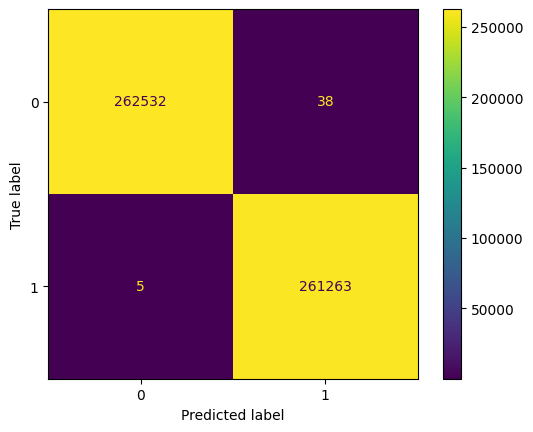

In [58]:
##Plotting Confusion matrix

cm = confusion_matrix(y_test, y_pred, labels=histbest.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=histbest.classes_)
disp.plot()
plt.show()

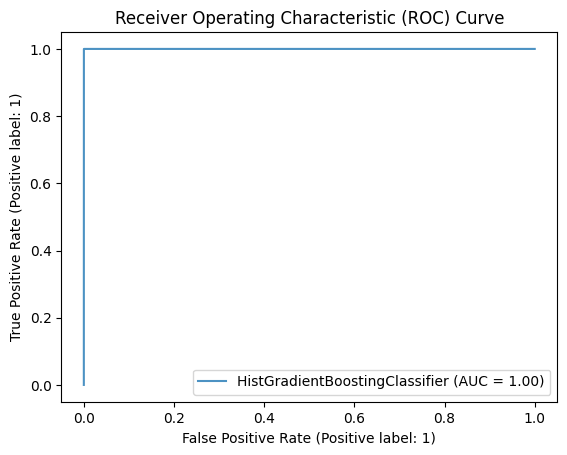

In [59]:
##Plotting ROC Curve

ax = plt.gca()
roc_display = RocCurveDisplay.from_estimator(histbest, X_test, y_test, ax=ax, alpha=0.8)
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()

In [60]:
print(sensitivity_specificity_support(y_test, y_pred))

(array([0.99985528, 0.99998086]), array([0.99998086, 0.99985528]), array([262570, 261268]))


In [61]:
print(sensitivity_specificity_support(y_test, y_pred, average='macro'))

(0.9999180696253503, 0.9999180696253503, None)


In [62]:
print(sensitivity_specificity_support(y_test, y_pred, average='micro'))

(0.9999179135534269, 0.9999179135534269, None)


In [63]:
print(sensitivity_specificity_support(y_test, y_pred, average='weighted'))

(0.9999179135534269, 0.9999182256972738, None)


# Training with Adaboost

In [ ]:
abc = AdaBoostClassifier()
abc.fit(X_train,y_train)
y_pred = abc.predict(X_test)

In [ ]:
accuracy_score(y_test,y_pred)

In [ ]:
confusion_matrix(y_test,y_pred)

In [ ]:
roc_auc_score(y_test,y_pred)

In [1]:
abc = AdaBoostClassifier()
param_grid = {
    'n_estimators' : [100, 200, 300, 500],
    'learning_rate' : [0.0001, 0.001, 0.01, 0.1, 1],
}

rand5 = RandomizedSearchCV(abc, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

NameError: name 'AdaBoostClassifier' is not defined

In [ ]:
with joblib.parallel_backend("dask", scatter=[X_train,y_train]):
    rand5.fit(X_train,y_train)

In [ ]:
rand5.best_params_

In [ ]:
rand5.best_score_

In [ ]:
##Training with best parameters
adabest = AdaBoostClassifier(n_estimators=500, learning_rate=1)
with joblib.parallel_backend("dask", scatter=[X_train,y_train]):
    adabest.fit(X_train,y_train)

y_pred = adabest.predict(X_test)

In [ ]:
print(classification_report_imbalanced(y_test,y_pred))

In [ ]:
##Plotting Confusion matrix

cm = confusion_matrix(y_test, y_pred, labels=adabest.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=adabest.classes_)
disp.plot()
plt.show()

In [ ]:
##Plotting ROC Curve

ax = plt.gca()
roc_display = RocCurveDisplay.from_estimator(adabest, X_test, y_test, ax=ax, alpha=0.8)
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()

In [ ]:
print(sensitivity_specificity_support(y_test, y_pred))

In [ ]:
print(sensitivity_specificity_support(y_test, y_pred, average='macro'))

In [ ]:
print(sensitivity_specificity_support(y_test, y_pred, average='micro'))

In [ ]:
print(sensitivity_specificity_support(y_test, y_pred, average='weighted'))